In [99]:
import numpy as np 
import pandas as pd 
import os

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [100]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib


In [101]:
df1= pd.read_csv("C:\\Users\\hp\\Desktop\\city_day.csv")

In [102]:
delhi_data= df1.groupby('City').get_group('Delhi')

In [103]:
delhi_data.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
10229,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
10230,Delhi,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,Severe
10231,Delhi,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,Moderate
10232,Delhi,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,Very Poor
10233,Delhi,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,Very Poor


In [104]:
delhi_data.shape


(2009, 16)

In [105]:
delhi_data.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,2007.000000,1932.000000,2007.000000,2007.000000,2009.000000,2000.000000,2009.000000,1899.000000,1925.00000,2009.000000,2009.000000,1228.000000,1999.000000
mean,117.196153,232.809229,38.985595,50.785182,58.567023,41.997150,1.976053,15.901253,51.32361,3.544480,17.185042,1.438339,259.487744
std,82.912945,121.873025,33.389456,22.696721,37.690350,17.301221,2.560253,7.966770,26.06234,2.431232,15.291597,2.377762,119.537333
min,10.240000,18.590000,3.570000,10.630000,0.000000,6.780000,0.000000,2.340000,6.94000,0.000000,0.000000,0.000000,29.000000
25%,57.095000,137.040000,15.895000,33.895000,31.150000,31.157500,0.910000,10.335000,33.71000,1.870000,6.650000,0.110000,161.500000
50%,94.620000,216.730000,27.200000,47.150000,52.750000,38.040000,1.240000,14.450000,44.44000,2.960000,12.750000,0.650000,257.000000
75%,153.030000,311.667500,50.790000,63.570000,75.360000,48.792500,1.870000,19.700000,60.84000,4.680000,23.200000,1.970000,345.500000
max,685.360000,796.880000,221.030000,162.500000,254.800000,166.700000,30.440000,71.560000,257.73000,20.640000,103.000000,23.300000,716.000000


In [106]:
# Count missing values for each column
missing_values = delhi_data.isnull().sum()

# Percentage of missing values
missing_percent = (missing_values / len(delhi_data)) * 100

# Combine into a nice dataframe
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    '% of Total Values': missing_percent
})

print(missing_summary)



            Missing Values  % of Total Values
City                     0           0.000000
Date                     0           0.000000
PM2.5                    2           0.099552
PM10                    77           3.832753
NO                       2           0.099552
NO2                      2           0.099552
NOx                      0           0.000000
NH3                      9           0.447984
CO                       0           0.000000
SO2                    110           5.475361
O3                      84           4.181185
Benzene                  0           0.000000
Toluene                  0           0.000000
Xylene                 781          38.875062
AQI                     10           0.497760
AQI_Bucket              10           0.497760


In [107]:
NUMERIC_COLS = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3',
                'Benzene','Toluene','Xylene','AQI']   # AQI included but we can recompute later
CATEGORICAL_COLS = ['City','AQI_Bucket']
TIMESTAMP_COL = 'Date'   # if your delhi_data used 'timestamp' earlier, set to 'timestamp'
FREQ = 'D'               

In [108]:
def preprocess_delhi(delhi_data):


    # 1) Ensure timestamp index (handle if column name is 'Date' or 'timestamp')
    if TIMESTAMP_COL in delhi_data.columns:
        delhi_data = delhi_data.rename(columns={TIMESTAMP_COL: 'timestamp'})
    # If it's already set as index with name 'timestamp' we keep it; otherwise set index:
    if 'timestamp' in delhi_data.columns:
        delhi_data['timestamp'] = pd.to_datetime(delhi_data['timestamp'])
        delhi_data = delhi_data.set_index('timestamp').sort_index()
    elif delhi_data.index.name != 'timestamp' and not isinstance(delhi_data.index, pd.DatetimeIndex):
        # try to coerce index
        delhi_data.index = pd.to_datetime(delhi_data.index)
        delhi_data.index.name = 'timestamp'
    else:
        delhi_data = delhi_data.sort_index()

In [111]:
delhi_data.replace({'--': np.nan, 'NA': np.nan, 'NaN': np.nan, 'nan': np.nan, ' ': np.nan, '': np.nan,
                'NoData': np.nan, 'ND': np.nan}, inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_11588\2329751942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delhi_data.replace({'--': np.nan, 'NA': np.nan, 'NaN': np.nan, 'nan': np.nan, ' ': np.nan, '': np.nan,


In [112]:
for c in NUMERIC_COLS:
        if c in delhi_data.columns:
            delhi_data[c] = pd.to_numeric(delhi_data[c], errors='coerce')

C:\Users\hp\AppData\Local\Temp\ipykernel_11588\836251922.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delhi_data[c] = pd.to_numeric(delhi_data[c], errors='coerce')


In [113]:
def handle_missing_values(delhi_data, numeric_cols):
    delhi_data = delhi_data.copy()

    # 1️⃣ Drop high-missing columns (>60% missing)
    missing_percent = delhi_data[numeric_cols].isna().mean() * 100
    drop_cols = missing_percent[missing_percent > 60].index.tolist()
    print(f"Dropping columns with >60% missing values: {drop_cols}")
    delhi_data.drop(columns=drop_cols, inplace=True)

    # Update numeric_cols after dropping
    numeric_cols = [col for col in numeric_cols if col not in drop_cols]

    # 2️⃣ Imputation - forward fill, backward fill, then median
    delhi_data[numeric_cols] = delhi_data[numeric_cols].ffill().bfill()
    delhi_data[numeric_cols] = delhi_data[numeric_cols].fillna(delhi_data[numeric_cols].median())

    return delhi_data, numeric_cols

# --- Run it ---
cleaned_data, cleaned_numeric_cols = handle_missing_values(delhi_data, NUMERIC_COLS)

print("✅ Missing value handling completed.")
print("Remaining missing values:\n", cleaned_data[cleaned_numeric_cols].isna().sum())


Dropping columns with >60% missing values: []
✅ Missing value handling completed.
Remaining missing values:
 PM2.5      0
PM10       0
NO         0
NO2        0
NOx        0
NH3        0
CO         0
SO2        0
O3         0
Benzene    0
Toluene    0
Xylene     0
AQI        0
dtype: int64


In [114]:
def clip_outliers(delhi_data, numeric_cols, target_col=None, lower_q=0.01, upper_q=0.99):
    delhi_data = delhi_data.copy()
    for col in numeric_cols:
        if col == target_col:  # Skip clipping target variable
            continue
        lower = delhi_data[col].quantile(lower_q)
        upper = delhi_data[col].quantile(upper_q)
        delhi_data[col] = delhi_data[col].clip(lower, upper)
    return delhi_data

# Example for AQI prediction:
cleaned_data = clip_outliers(cleaned_data, cleaned_numeric_cols, target_col='AQI')
print("✅ Outlier clipping done for input features (AQI left untouched).")


✅ Outlier clipping done for input features (AQI left untouched).


In [115]:
delhi_data= delhi_data.groupby('City').get_group('Delhi')

In [116]:
cleaned_data.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000
mean,116.199046,232.991949,38.798304,50.642536,58.367306,41.721692,1.938319,15.951641,50.583988,3.522452,17.068413,0.970148,258.632653
std,78.712542,116.444269,32.631741,22.142188,36.884332,15.889382,2.324542,7.714716,24.361336,2.339352,14.777691,1.661586,119.883918
min,21.138000,46.385600,5.470800,16.600000,3.533200,17.661200,0.000000,2.340000,18.256400,0.100000,0.000000,0.000000,29.000000
25%,57.080000,138.560000,15.900000,33.900000,31.150000,31.110000,0.910000,10.330000,34.050000,1.870000,6.650000,0.000000,159.000000
50%,94.490000,219.940000,27.200000,47.020000,52.750000,38.010000,1.240000,14.700000,43.290000,2.960000,12.750000,0.180000,257.000000
75%,152.990000,309.370000,50.720000,63.570000,75.360000,48.680000,1.870000,20.360000,59.880000,4.680000,23.200000,1.440000,345.000000
max,388.121200,546.515600,155.510800,121.074000,178.102400,111.449200,11.739200,46.098400,140.645600,10.678400,74.447200,10.458400,716.000000


In [118]:
cleaned_data['AQI'].head()   


10229    472.0
10230    454.0
10231    143.0
10232    319.0
10233    325.0
Name: AQI, dtype: float64

In [119]:
cleaned_data.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
10229,Delhi,2015-01-01,313.22,546.5156,69.16,36.39,110.59,33.8500,11.7392,9.25,41.68,10.6784,24.86,9.84,472.0,Severe
10230,Delhi,2015-01-02,186.18,269.5500,62.09,32.87,88.14,31.8300,9.5400,6.65,29.97,10.5500,20.09,4.29,454.0,Severe
10231,Delhi,2015-01-03,87.18,131.9000,25.73,30.31,47.95,69.5500,10.6100,2.65,19.71,3.9100,10.23,1.99,143.0,Moderate
10232,Delhi,2015-01-04,151.84,241.8400,25.01,36.91,48.62,111.4492,11.5400,4.63,25.36,4.2600,9.71,3.34,319.0,Very Poor
10233,Delhi,2015-01-05,146.60,219.1300,14.01,34.92,38.25,111.4492,9.2000,3.33,23.20,2.8000,6.21,2.96,325.0,Very Poor


In [121]:
# Show rows where AQI_Bucket is missing in cleaned_data
missing_aqi_bucket_rows = cleaned_data[cleaned_data['AQI_Bucket'].isna()]

print(f"Number of rows with missing AQI_Bucket: {len(missing_aqi_bucket_rows)}")
display(missing_aqi_bucket_rows)


Number of rows with missing AQI_Bucket: 10


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
10799,Delhi,2016-07-24,59.400,124.47,15.95,56.56,69.2000,38.4400,1.45,8.91,65.4200,2.97,9.41,0.0,163.0,NaN
11133,Delhi,2017-06-23,44.080,160.22,39.17,103.29,7.4500,52.7300,0.00,23.51,39.6100,0.38,0.00,0.0,124.0,NaN
11184,Delhi,2017-08-13,21.830,246.98,24.86,35.39,3.5332,17.9200,0.00,23.51,39.6100,0.10,0.00,0.0,45.0,NaN
11185,Delhi,2017-08-14,26.540,246.98,27.43,88.07,6.4200,34.8000,0.00,23.51,39.6100,0.10,0.00,0.0,45.0,NaN
11193,Delhi,2017-08-22,46.000,246.98,14.50,38.70,3.5332,17.6612,0.00,23.51,39.6100,0.30,0.00,0.0,42.0,NaN
11194,Delhi,2017-08-23,36.540,246.98,31.42,43.43,4.7000,22.3300,0.00,23.51,39.6100,0.31,0.00,0.0,42.0,NaN
11197,Delhi,2017-08-26,62.330,246.98,40.14,37.65,3.5332,23.2600,0.00,23.51,39.6100,0.24,0.00,0.0,104.0,NaN
11198,Delhi,2017-08-27,34.300,246.98,62.68,34.06,4.5500,29.1900,0.00,23.51,39.6100,0.23,0.00,0.0,104.0,NaN
11199,Delhi,2017-08-28,23.820,246.98,20.79,27.89,3.5332,17.6612,0.00,2.34,18.2564,0.19,0.25,0.0,104.0,NaN
11200,Delhi,2017-08-29,21.138,246.98,22.97,69.80,4.7400,27.7700,0.00,2.34,18.2564,0.18,0.00,0.0,104.0,NaN


In [122]:
cleaned_data.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000
mean,116.199046,232.991949,38.798304,50.642536,58.367306,41.721692,1.938319,15.951641,50.583988,3.522452,17.068413,0.970148,258.632653
std,78.712542,116.444269,32.631741,22.142188,36.884332,15.889382,2.324542,7.714716,24.361336,2.339352,14.777691,1.661586,119.883918
min,21.138000,46.385600,5.470800,16.600000,3.533200,17.661200,0.000000,2.340000,18.256400,0.100000,0.000000,0.000000,29.000000
25%,57.080000,138.560000,15.900000,33.900000,31.150000,31.110000,0.910000,10.330000,34.050000,1.870000,6.650000,0.000000,159.000000
50%,94.490000,219.940000,27.200000,47.020000,52.750000,38.010000,1.240000,14.700000,43.290000,2.960000,12.750000,0.180000,257.000000
75%,152.990000,309.370000,50.720000,63.570000,75.360000,48.680000,1.870000,20.360000,59.880000,4.680000,23.200000,1.440000,345.000000
max,388.121200,546.515600,155.510800,121.074000,178.102400,111.449200,11.739200,46.098400,140.645600,10.678400,74.447200,10.458400,716.000000


In [123]:
import numpy as np

# Your function to map AQI to Bucket
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

# Fill missing AQI_Bucket based on AQI values
cleaned_data['AQI_Bucket'] = cleaned_data.apply(
    lambda row: get_AQI_bucket(row['AQI']) if pd.isna(row['AQI_Bucket']) else row['AQI_Bucket'],
    axis=1
)

# Verify if there are still any missing AQI_Bucket values
print("Remaining missing AQI_Bucket values:", cleaned_data['AQI_Bucket'].isna().sum())


Remaining missing AQI_Bucket values: 0


In [124]:
pm_diff = cleaned_data['PM2.5'].diff().abs()
suspicious_spikes = cleaned_data[pm_diff > cleaned_data['PM2.5'].quantile(0.99)]
print(suspicious_spikes[['PM2.5', 'AQI']])


Empty DataFrame
Columns: [PM2.5, AQI]
Index: []


In [125]:
pm_diff = cleaned_data['PM2.5'].diff().abs()

# Compute threshold based on distribution of daily changes
diff_threshold = pm_diff.quantile(0.99)

suspicious_spikes = cleaned_data[pm_diff > diff_threshold]
print(f"Threshold for suspicious PM2.5 jumps: {diff_threshold:.2f}")
print(f"Number of suspicious spikes detected: {len(suspicious_spikes)}")
display(suspicious_spikes[['PM2.5', 'AQI']])


Threshold for suspicious PM2.5 jumps: 135.21
Number of suspicious spikes detected: 21


,PM2.5,AQI
10532,245.9700,340.0
10539,353.8600,483.0
10540,217.5500,451.0
10586,129.0800,314.0
10602,158.4300,408.0
10951,364.1500,470.0
10953,232.4100,412.0
11014,388.1212,449.0
11017,178.5000,363.0
11252,388.1212,497.0


In [126]:
# Flag suspicious points where AQI seems too high for PM2.5
suspicious_spikes['AQI_PM_ratio'] = suspicious_spikes['AQI'] / suspicious_spikes['PM2.5']

# Let's look at extreme ratios
print(suspicious_spikes[['PM2.5', 'AQI', 'AQI_PM_ratio']].sort_values(by='AQI_PM_ratio', ascending=False))


          PM2.5    AQI  AQI_PM_ratio
12036   94.6200  322.0      3.403086
11703   94.4400  320.0      3.388395
10602  158.4300  408.0      2.575270
12009  174.0300  438.0      2.516807
10586  129.0800  314.0      2.432600
11710  175.4900  413.0      2.353410
11315  157.7200  370.0      2.345929
11634  177.8800  411.0      2.310546
10540  217.5500  451.0      2.073087
11017  178.5000  363.0      2.033613
11253  213.1200  404.0      1.895646
10953  232.4100  412.0      1.772729
11705  271.9600  383.0      1.408295
10532  245.9700  340.0      1.382282
11270  388.1212  532.0      1.370706
10539  353.8600  483.0      1.364947
10951  364.1500  470.0      1.290677
11252  388.1212  497.0      1.280528
11633  361.9800  424.0      1.171335
11636  388.1212  452.0      1.164585
11014  388.1212  449.0      1.156855


C:\Users\hp\AppData\Local\Temp\ipykernel_11588\1536537818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suspicious_spikes['AQI_PM_ratio'] = suspicious_spikes['AQI'] / suspicious_spikes['PM2.5']


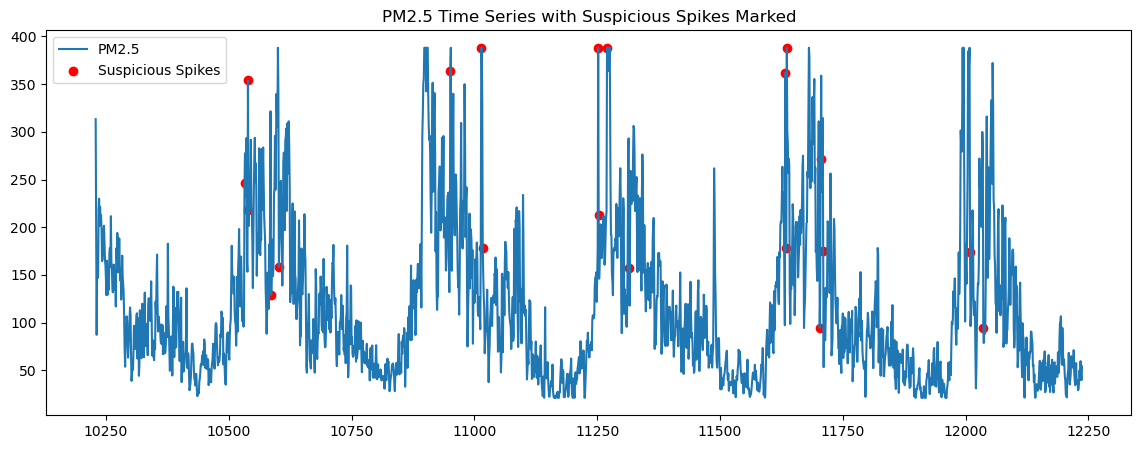

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(cleaned_data['PM2.5'], label='PM2.5')
plt.scatter(suspicious_spikes.index, suspicious_spikes['PM2.5'], color='red', label='Suspicious Spikes')
plt.legend()
plt.title("PM2.5 Time Series with Suspicious Spikes Marked")
plt.show()


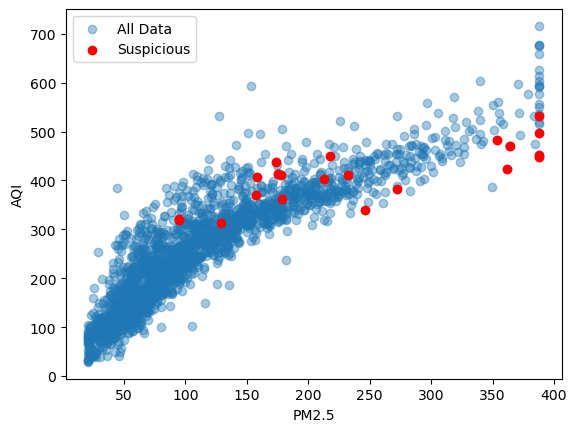

In [128]:
import matplotlib.pyplot as plt

plt.scatter(cleaned_data['PM2.5'], cleaned_data['AQI'], alpha=0.4, label='All Data')
plt.scatter(suspicious_spikes['PM2.5'], suspicious_spikes['AQI'], color='red', label='Suspicious')
plt.xlabel("PM2.5")
plt.ylabel("AQI")
plt.legend()
plt.show()


In [129]:
cols_to_check = ['PM2.5','PM10','NO2','O3','AQI']
print(suspicious_spikes[cols_to_check])


          PM2.5      PM10      NO2      O3    AQI
10532  245.9700  274.0600   35.110   42.32  340.0
10539  353.8600  496.6100   86.590  107.69  483.0
10540  217.5500  356.9200   75.980  103.40  451.0
10586  129.0800  486.6600   55.010   32.42  314.0
10602  158.4300  324.6400   60.630  100.54  408.0
10951  364.1500  546.5156  121.074   45.00  470.0
10953  232.4100  346.5700   59.880   38.99  412.0
11014  388.1212  104.8200   42.200   55.11  449.0
11017  178.5000  255.6500   72.800   35.64  363.0
11252  388.1212  387.1300   54.760   41.14  497.0
11253  213.1200  317.5200   50.130   34.52  404.0
11270  388.1212  546.5156   65.170   56.06  532.0
11315  157.7200  241.3800   50.730   48.84  370.0
11633  361.9800  500.0100   48.250   45.00  424.0
11634  177.8800  312.8700   43.780   45.01  411.0
11636  388.1212  509.7300   64.570   38.35  452.0
11703   94.4400  173.9400   42.160   31.33  320.0
11705  271.9600  424.0700   83.750   33.75  383.0
11710  175.4900  289.4000   63.040   32.77  413.0


In [130]:
# 1️⃣ Get the indices of rows with AQI_PM_ratio > 3 (already calculated in suspicious_spikes)
to_drop_idx = suspicious_spikes[suspicious_spikes['AQI_PM_ratio'] > 3].index

print(f"Dropping {len(to_drop_idx)} rows with AQI_PM_ratio > 3...")
# Show only columns that exist in cleaned_data (no AQI_PM_ratio there)
print(cleaned_data.loc[to_drop_idx, ['PM2.5','AQI']])

# 2️⃣ Drop them from cleaned_data
cleaned_data = cleaned_data.drop(index=to_drop_idx)

print(f"✅ New shape after dropping: {cleaned_data.shape}")


Dropping 2 rows with AQI_PM_ratio > 3...
       PM2.5    AQI
11703  94.44  320.0
12036  94.62  322.0
✅ New shape after dropping: (2007, 16)


In [131]:
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'], format='%Y-%m-%d', errors='coerce')

# Verify conversion
print(cleaned_data['Date'].dtypes)
print(cleaned_data.head())

datetime64[ns]
        City       Date   PM2.5      PM10     NO    NO2     NOx       NH3  \
10229  Delhi 2015-01-01  313.22  546.5156  69.16  36.39  110.59   33.8500   
10230  Delhi 2015-01-02  186.18  269.5500  62.09  32.87   88.14   31.8300   
10231  Delhi 2015-01-03   87.18  131.9000  25.73  30.31   47.95   69.5500   
10232  Delhi 2015-01-04  151.84  241.8400  25.01  36.91   48.62  111.4492   
10233  Delhi 2015-01-05  146.60  219.1300  14.01  34.92   38.25  111.4492   

            CO   SO2     O3  Benzene  Toluene  Xylene    AQI AQI_Bucket  
10229  11.7392  9.25  41.68  10.6784    24.86    9.84  472.0     Severe  
10230   9.5400  6.65  29.97  10.5500    20.09    4.29  454.0     Severe  
10231  10.6100  2.65  19.71   3.9100    10.23    1.99  143.0   Moderate  
10232  11.5400  4.63  25.36   4.2600     9.71    3.34  319.0  Very Poor  
10233   9.2000  3.33  23.20   2.8000     6.21    2.96  325.0  Very Poor  


In [132]:
cleaned_data['day_of_week'] = cleaned_data['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
cleaned_data['month'] = cleaned_data['Date'].dt.month
cleaned_data['year'] = cleaned_data['Date'].dt.year


In [133]:
cleaned_data['PM2.5_lag1'] = cleaned_data['PM2.5'].shift(1)  # yesterday's PM2.5
cleaned_data['PM2.5_lag3'] = cleaned_data['PM2.5'].shift(3)  # 3 days ago
cleaned_data['PM2.5_lag7'] = cleaned_data['PM2.5'].shift(7)  # 3 days ago


In [134]:
cleaned_data['PM2.5_rolling3'] = cleaned_data['PM2.5'].rolling(window=3).mean()
cleaned_data['PM2.5_rolling7'] = cleaned_data['PM2.5'].rolling(window=7).mean()


In [135]:
cleaned_data['NOx_CO_interaction'] = cleaned_data['NOx'] * cleaned_data['CO']
cleaned_data['PM_sum'] = cleaned_data['PM2.5'] + cleaned_data['PM10']


In [136]:
cleaned_data['is_weekend'] = (cleaned_data['day_of_week'] >= 5).astype(int)


In [137]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9]:
        return 'monsoon'
    else:
        return 'post_monsoon'

cleaned_data['season'] = cleaned_data['month'].apply(get_season)


In [138]:
cleaned_data.head(10)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,year,PM2.5_lag1,PM2.5_lag3,PM2.5_lag7,PM2.5_rolling3,PM2.5_rolling7,NOx_CO_interaction,PM_sum,is_weekend,season
10229,Delhi,2015-01-01,313.22,546.5156,69.16,36.39,110.59,33.8500,11.7392,9.25,...,2015,NaN,NaN,NaN,NaN,NaN,1298.238128,859.7356,0,winter
10230,Delhi,2015-01-02,186.18,269.5500,62.09,32.87,88.14,31.8300,9.5400,6.65,...,2015,313.22,NaN,NaN,NaN,NaN,840.855600,455.7300,0,winter
10231,Delhi,2015-01-03,87.18,131.9000,25.73,30.31,47.95,69.5500,10.6100,2.65,...,2015,186.18,NaN,NaN,195.526667,NaN,508.749500,219.0800,1,winter
10232,Delhi,2015-01-04,151.84,241.8400,25.01,36.91,48.62,111.4492,11.5400,4.63,...,2015,87.18,313.22,NaN,141.733333,NaN,561.074800,393.6800,1,winter
10233,Delhi,2015-01-05,146.60,219.1300,14.01,34.92,38.25,111.4492,9.2000,3.33,...,2015,151.84,186.18,NaN,128.540000,NaN,351.900000,365.7300,0,winter
10234,Delhi,2015-01-06,149.58,252.1000,17.21,37.84,42.46,111.4492,9.4400,3.66,...,2015,146.60,87.18,NaN,149.340000,NaN,400.822400,401.6800,0,winter
10235,Delhi,2015-01-07,217.87,376.5100,26.99,40.15,52.41,111.4492,9.7800,5.82,...,2015,149.58,151.84,NaN,171.350000,178.924286,512.569800,594.3800,0,winter
10236,Delhi,2015-01-08,229.90,360.9500,23.34,43.16,51.21,111.4492,11.0100,3.31,...,2015,217.87,146.60,313.22,199.116667,167.021429,563.822100,590.8500,0,winter
10237,Delhi,2015-01-09,201.66,397.4300,19.18,38.56,45.60,111.4492,11.0900,3.48,...,2015,229.90,149.58,186.18,216.476667,169.232857,505.704000,599.0900,0,winter
10238,Delhi,2015-01-10,221.02,361.7400,24.79,46.39,55.19,111.4492,9.7000,5.91,...,2015,201.66,217.87,87.18,217.526667,188.352857,535.343000,582.7600,1,winter


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


🌲 Random Forest RMSE: 20.06, R²: 0.969


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


⚡ XGBoost RMSE: 19.57, R²: 0.970


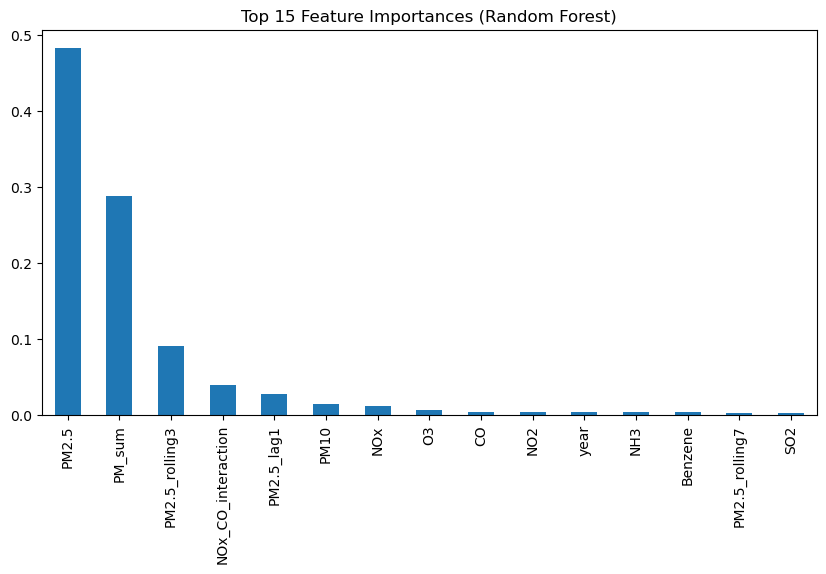

In [139]:
!pip install xgboost
-----
# -----------------
target = "AQI"
features = delhi_data_model.drop(columns=["City", "Date", "AQI", "AQI_Bucket"])

# One-hot encode season (categorical feature)
features = pd.get_dummies(features, columns=["season"], drop_first=True)how 

X = features
y = delhi_data_model[target]

# -----------------
# 3️⃣ Train-Test Split
# -----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # time-series → no shuffling
)

# -----------------
# 4️⃣ Train Random Forest
# -----------------
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
rf_r2 = r2_score(y_test, rf_preds)

print(f"🌲 Random Forest RMSE: {rf_rmse:.2f}, R²: {rf_r2:.3f}")

# -----------------
# 5️⃣ Train XGBoost
# -----------------
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)
xgb_r2 = r2_score(y_test, xgb_preds)

print(f"⚡ XGBoost RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.3f}")

# -----------------
# 6️⃣ Feature Importance (Optional)
# -----------------
import matplotlib.pyplot as plt

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,5))
top_features.plot(kind='bar')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


In [140]:
import xgboost as xgb
print(xgb.__version__)


3.0.5


In [141]:
# Assuming your dataframe is called delhi_data and column name is 'AQI'
aqi_std = cleaned_data['AQI'].std()

print("Standard Deviation of AQI:", aqi_std)




Standard Deviation of AQI: 119.92747844691777


In [144]:
# If your column is named 'AQI'
cleaned_data['AQI'].describe()


count    2007.000000
mean      258.570503
std       119.927478
min        29.000000
25%       159.000000
50%       257.000000
75%       345.000000
max       716.000000
Name: AQI, dtype: float64

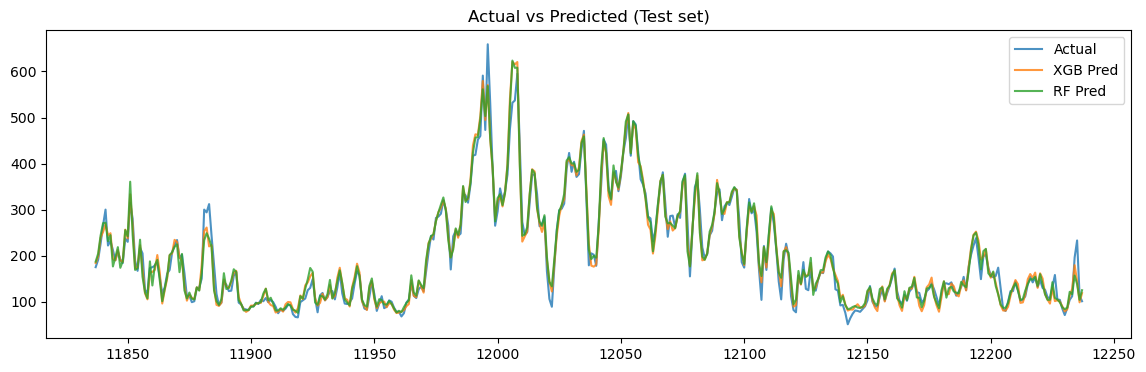

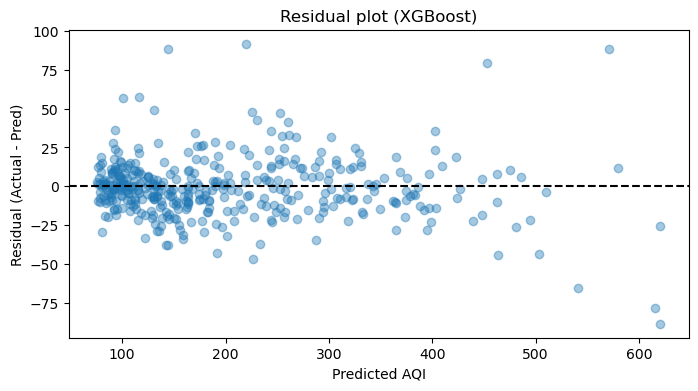

XGB RMSE: 19.56767349944418 MAE: 13.651593990325928
RF  RMSE: 20.058135928799125 MAE: 13.67922745857416


In [145]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# preds already exist: rf_preds, xgb_preds (and y_test)

# a) time series plot of actual vs predicted
test_idx = y_test.index
plt.figure(figsize=(14,4))
plt.plot(test_idx, y_test, label='Actual', alpha=0.8)
plt.plot(test_idx, xgb_preds, label='XGB Pred', alpha=0.8)
plt.plot(test_idx, rf_preds, label='RF Pred', alpha=0.8)
plt.legend(); plt.title('Actual vs Predicted (Test set)')
plt.show()

# b) residuals
resid = y_test - xgb_preds
plt.figure(figsize=(8,4))
plt.scatter(xgb_preds, resid, alpha=0.4)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicted AQI'); plt.ylabel('Residual (Actual - Pred)')
plt.title('Residual plot (XGBoost)')
plt.show()

# c) error metrics (add MAE)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
rf_mae  = mean_absolute_error(y_test, rf_preds)
print("XGB RMSE:", xgb_rmse, "MAE:", xgb_mae)
print("RF  RMSE:", rf_rmse,  "MAE:", rf_mae)


In [146]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# Use the same X, y you created earlier
tscv = TimeSeriesSplit(n_splits=5)

rf_rmse_scores = []
xgb_rmse_scores = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train RF
    rf.fit(X_train, y_train)
    rf_preds = rf.predict(X_test)
    rf_rmse_scores.append(mean_squared_error(y_test, rf_preds, squared=False))
    
    # Train XGB
    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict(X_test)
    xgb_rmse_scores.append(mean_squared_error(y_test, xgb_preds, squared=False))

print("Random Forest RMSE per split:", rf_rmse_scores)
print("XGBoost RMSE per split:", xgb_rmse_scores)

print("Average RF RMSE:", np.mean(rf_rmse_scores))
print("Average XGB RMSE:", np.mean(xgb_rmse_scores))


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

Random Forest RMSE per split: [48.21543058951257, 73.52294584806583, 33.597187305137496, 25.068173568532668, 19.392716121222904]
XGBoost RMSE per split: [45.96764629109747, 62.98706193074843, 31.13197734588933, 23.674504356387082, 18.896928151506454]
Average RF RMSE: 39.9592906864943
Average XGB RMSE: 36.53162361512575


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
